# Exploratory Data Analysis

In [32]:
TRAIN_DIR = '../src/image_segmentation/assets/data/train_v2/'
TEST_DIR = '../src/image_segmentation/assets/data/test_v2/'

H = 768
W = 768

## Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import PIL

## Load Datasets

In [14]:
train_seg = pd.read_csv('../src/image_segmentation/assets/data/train_ship_segmentations_v2.csv')

In [18]:
train = os.listdir(TRAIN_DIR) 
test = os.listdir(TEST_DIR)

## Analysis of Training Data Segmentations

In [19]:
train_seg.head(5)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [20]:
train_seg.shape

(231723, 2)

In [21]:
masks = train_seg.dropna()

n_img = train_seg.ImageId.nunique()
n_not_empty_img = masks.ImageId.nunique()
n_empty_img = n_img - n_not_empty_img

print(f"Total amount of images: {n_img}")
print(f"Number of empty images: {n_empty_img}")
print(f"Number of images with ships: {n_not_empty_img}")
print(f"Number of ships on the all images: {len(masks)}")

Total amount of images: 192556
Number of empty images: 150000
Number of images with ships: 42556
Number of ships on the all images: 81723


Text(0.5, 1.0, 'Training Data Distribution')

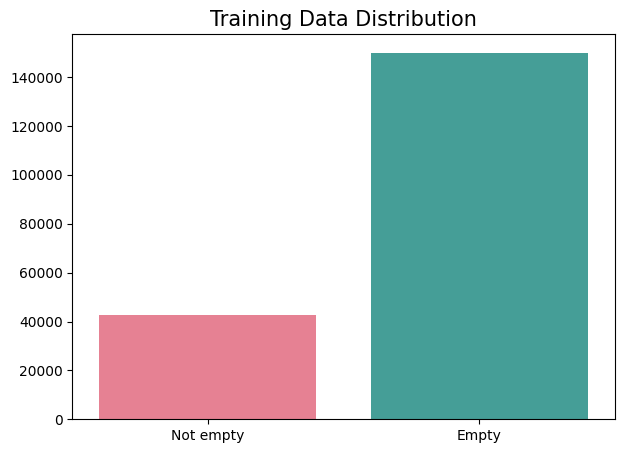

In [23]:
plt.figure(figsize=(7,5))
sns.barplot(x=['Not empty', 'Empty'], y=[n_not_empty_img, n_empty_img], palette='husl')
plt.title("Training Data Distribution", size=15)

Text(0.5, 1.0, 'Number of Ships per Image')

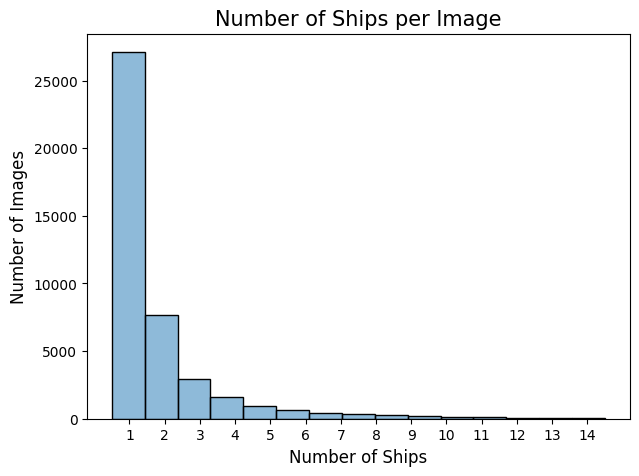

In [24]:
plt.figure(figsize=(7,5))
data = masks.groupby('ImageId').count()
sns.histplot(data=data-0.5, bins=data.max()[0], legend=False)
plt.xticks(np.arange(1, data.max()[0]))
plt.xlabel('Number of Ships', size=12)
plt.ylabel('Number of Images', size=12)
plt.title("Number of Ships per Image", size=15)

As we can see training dataset is quite imbalanced and has a lot of empty images (without ships).

## Image Visualization and Analysis

In [25]:
print(f"Number of train files: {len(train)}")
print(f"Number of test files: {len(test)}")
print(f"Image resolution: {PIL.Image.open(TRAIN_DIR + train[0]).size}")

Number of train files: 192556
Number of test files: 15606
Image resolution: (768, 768)


Text(0.5, 0.98, 'Examples of Images with Ships')

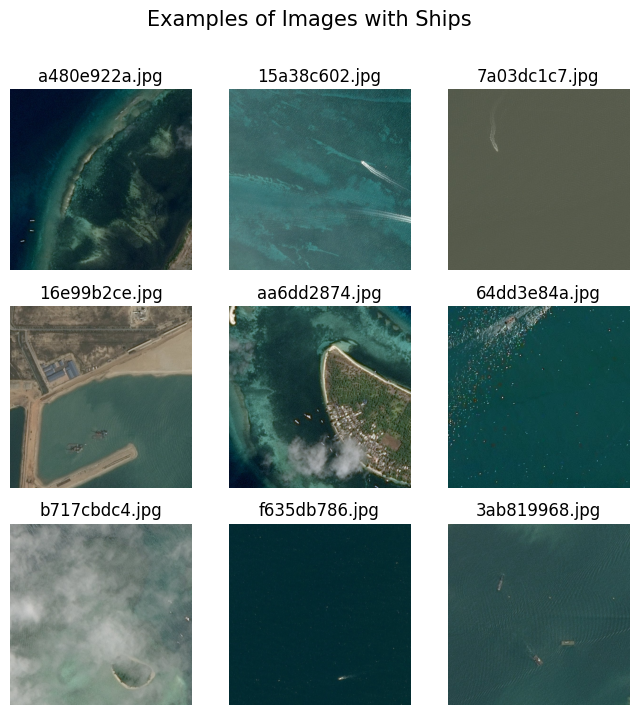

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8))

not_empty_img = masks.sample(9)['ImageId'].values

for i, img in enumerate(not_empty_img):
    x = i // 3
    y = i % 3
    ax[x,y].imshow(PIL.Image.open(TRAIN_DIR + img))
    ax[x,y].axis('off')
    ax[x,y].set_title(img)

plt.suptitle('Examples of Images with Ships', size=15)

Text(0.5, 0.98, 'Examples of Images without Ships')

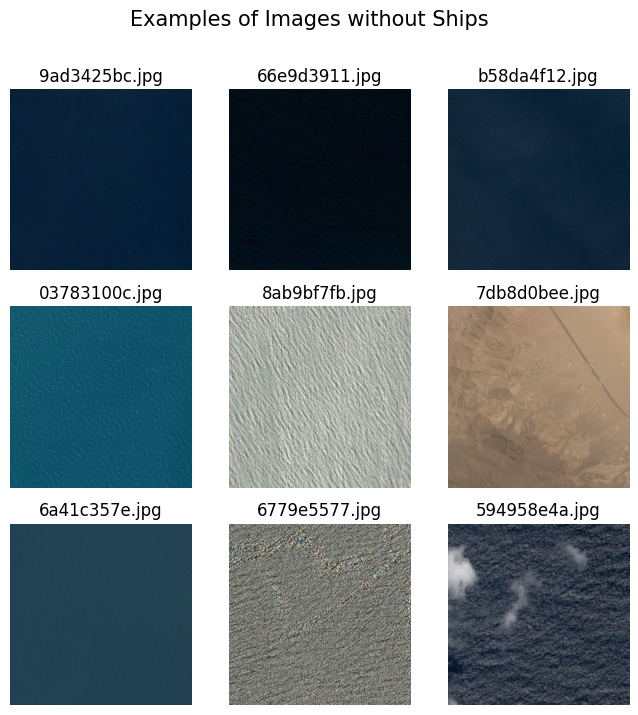

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8))

empty_img = train_seg.EncodedPixels.isna()
empty_img = train_seg.loc[empty_img[empty_img].index].sample(9)['ImageId'].values

for i, img in enumerate(empty_img):
    x = i // 3
    y = i % 3
    ax[x,y].imshow(PIL.Image.open(TRAIN_DIR + img))
    ax[x,y].axis('off')
    ax[x,y].set_title(img)

plt.suptitle('Examples of Images without Ships', size=15)

In [29]:
def rle_to_mask(encoded_pixels):
    '''
    Convert RLE-encoded values into the mask
    @param encoded_pixels: rle-string
    @return: list of pixel coordinates that represent the mask
    '''
    encoded_pixels = [int(i) for i in encoded_pixels.split()]
    decoded_pixels = []
    
    for i in range(0, len(encoded_pixels), 2):
        start = encoded_pixels[i]                        # list with start pixels
        stop = encoded_pixels[i] + encoded_pixels[i+1]   # list with stop pixels
        for j in range(start, stop):
            decoded_pixels.append((j % 768, j // 768))   # calculates the x and y coordinates
                                                         # for ship pixels and save them in list
    return decoded_pixels

Text(0.5, 0.98, 'Examples of Masks with Ships')

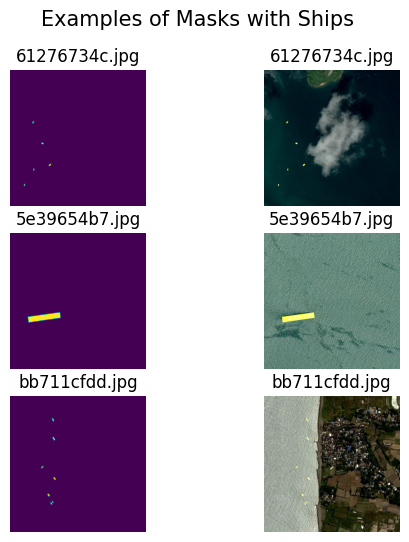

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(6, 6))

imgs = train_seg.loc[masks.index].sample(3)

for i in range(3):
    picture = np.zeros((768, 768))                                      # make a blank mask with zeros

    for j in masks[masks['ImageId'] == imgs.iloc[i][0]].EncodedPixels:  # find all masks for the particular image
            m = rle_to_mask(j)                                          # find ship pixels
            picture[tuple(zip(*m))] = 1                                 # map ship pixels on the (768, 768) matrix
        
    ax[i,0].imshow(picture)
    ax[i,0].axis('off')
    ax[i,0].set_title(imgs.iloc[i][0])
    
    
for i in range(3):
    picture = np.array(PIL.Image.open(TRAIN_DIR + imgs.iloc[i][0]))     # open image

    for j in masks[masks['ImageId'] == imgs.iloc[i][0]].EncodedPixels:  # find all masks for the particular image
        m = rle_to_mask(j)                                              # find ship pixels
        for a, b in m:
            picture[a,b,[0,1]] = 255                                    # map ship pixels on the (768, 768, 3) picture        
            
    ax[i,1].imshow(picture)
    ax[i,1].axis('off')
    ax[i,1].set_title(imgs.iloc[i][0])

plt.suptitle('Examples of Masks with Ships', size=15)